# Imports

In [1]:
from Bio import AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo import draw
from Bio import SeqIO
from Bio import Phylo, AlignIO
import subprocess
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

# Read sequence data and metadata
Read in the SARS-CoV-2 multiple sequence alignment.

12 SARS-CoV-2 genomic sequences from different locations and hosts were retrieved from NCBI Virus and aligned using the alignment function provided by the platform (https://www.ncbi.nlm.nih.gov/labs/virus/vssi/).

MSA.fasta was created by replacing the sequence header of the downloaded ncbi msa file with only the accession id and the file suffix -aln with .fasta.

In [2]:
align = AlignIO.read("MSA.fasta", "fasta")
print(align)

SingleLetterAlphabet() alignment with 12 rows and 29930 columns
ATATTAGGTTTTTACCTTCCCAGGTAACAAACCAACTAACTCTC...AAA MG772933.1
---------------------------------------CTTTC...--- MT451694.1
----------------------------------ACCAACTTTC...--- MT658507.1
--TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT641501.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT350282.1
---------TTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT263074.1
----------------------------------------TTTC...--- MT576584.1
------------------------------------------TC...--- MT635269.1
--------------------------------------------...--- MT582453.1
--------------------------------------------...--- MT525950.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MN908947.3
--------------------------------------ACTTTC...--- MT641645.1


### Process metadata 

The metadata file was downloaded from https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&ids=MN908947%20MG772933%20MT658507%20MT576584%20MT582453%20MT525950%20MT641501%20MT350282%20MT263074%20MT641645%20MT451694%20MT635269 .

For TreeTime and Nextstrain augur:
- matched MSA sequence names and accession ids in  metadata file
- renamed collection date column in metadata to "date" (datetime format)


For Nextstrain augur refine:
- created the columns "strain" and "virus" in addition to "date" (strain = accession, virus = species)
(https://nextstrain.org/docs/tutorials/zika)

In [104]:
#accession_metainfo = pd.read_csv("original_data/sequences.csv", index_col=0)

#accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
#accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')

# TreeTime and augur require the alignment file and metadata to have matching sequence names
#new_names = []
#for elem in accession_metainfo.Accession.values:
#    if elem.startswith('MN'):
#        new_names.append(elem+'.3')
#    else:
#        new_names.append(elem+'.1')
#        accession_metainfo.Accession = new_names

# Nextstrain augur requires the metadata columns strain, virus and date
#accession_metainfo['strain'] = accession_metainfo.Accession
#accession_metainfo['virus'] = accession_metainfo.Species

#accession_metainfo.to_csv("sequence_metadata.csv")

In [3]:
accession_metainfo = pd.read_csv("sequence_metadata.csv", index_col=0)
accession_metainfo.head()

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus
0,MT658507.1,2020-06-23T00:00:00Z,Severe acute respiratory syndrome-related coro...,29799,Egypt,Homo sapiens,oronasopharynx,2020-06-02,MT658507.1,Severe acute respiratory syndrome-related coro...
1,MT641501.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29868,USA: Washington,Homo sapiens,NaN,2020-04-11,MT641501.1,Severe acute respiratory syndrome-related coro...
2,MT641645.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29813,Australia: Northern Territory,Homo sapiens,NaN,2020-02-21,MT641645.1,Severe acute respiratory syndrome-related coro...
3,MT635269.1,2020-06-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,29800,"India: Gujarat, Ahmedabad",Homo sapiens,NaN,2020-06-03,MT635269.1,Severe acute respiratory syndrome-related coro...
4,MT582453.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582453.1,Severe acute respiratory syndrome-related coro...


# Infer phlyogeny
### Based on the MSA, a distance matrix is calculated for the 12 SARS-CoV2 sequences using the identity substitution model.

The identity substitution model assumes that each RNA base can only be maximally similar to itself but not transform into another base. Based on this assumption, two positions in a genomic MSA can only be considered identical (score = 1) or different (score = 0).

- Reading alignments, computing distance matrix, applying and visualizin UPGMA-inferred phylogeny: https://github.com/simonjuleseric2/covid_sequence/blob/master/coronavirus_sequence_analis.ipynb


In [4]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm = calculator.get_distance(align)

### Infer phylogeny using the UPGMA algorithm

UPGMA:
- distance based
- bottom-up hierarchical
- assumes a constant mutation rate

Goal:
- get general phylogeny of the SARS-CoV-2 genomes only based on sequence distance

In [5]:
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

#
code=accession_metainfo["Accession"]
host=accession_metainfo["Host"]
loc=accession_metainfo["Geo_Location"]

In [6]:
# function for plotting the phylogenetic tree
def get_label(leaf):
    searchname=leaf.name
    for i in range(0, len(code)):
        if searchname==code[i]:
            name=host[i] + ": " + loc[i]
            return name

In [7]:
print(tree)

Tree(rooted=True)
    Clade(branch_length=0, name='Inner11')
        Clade(branch_length=0.05995839249916471, name='Inner10')
            Clade(branch_length=0.0024567741396591784, name='Inner9')
                Clade(branch_length=0.0014518250918810795, name='Inner7')
                    Clade(branch_length=0.000801871032408974, name='Inner1')
                        Clade(branch_length=0.0001002338790511148, name='MN908947.3')
                        Clade(branch_length=0.0001002338790511148, name='MT350282.1')
                    Clade(branch_length=0.00036752422318747646, name='Inner4')
                        Clade(branch_length=0.0005345806882726123, name='MT263074.1')
                        Clade(branch_length=0.0005345806882726123, name='MT641501.1')
                Clade(branch_length=0.0012471809221516646, name='Inner8')
                    Clade(branch_length=0.0005951386568660497, name='Inner2')
                        Clade(branch_length=0.0003508185766789018, name='MT525

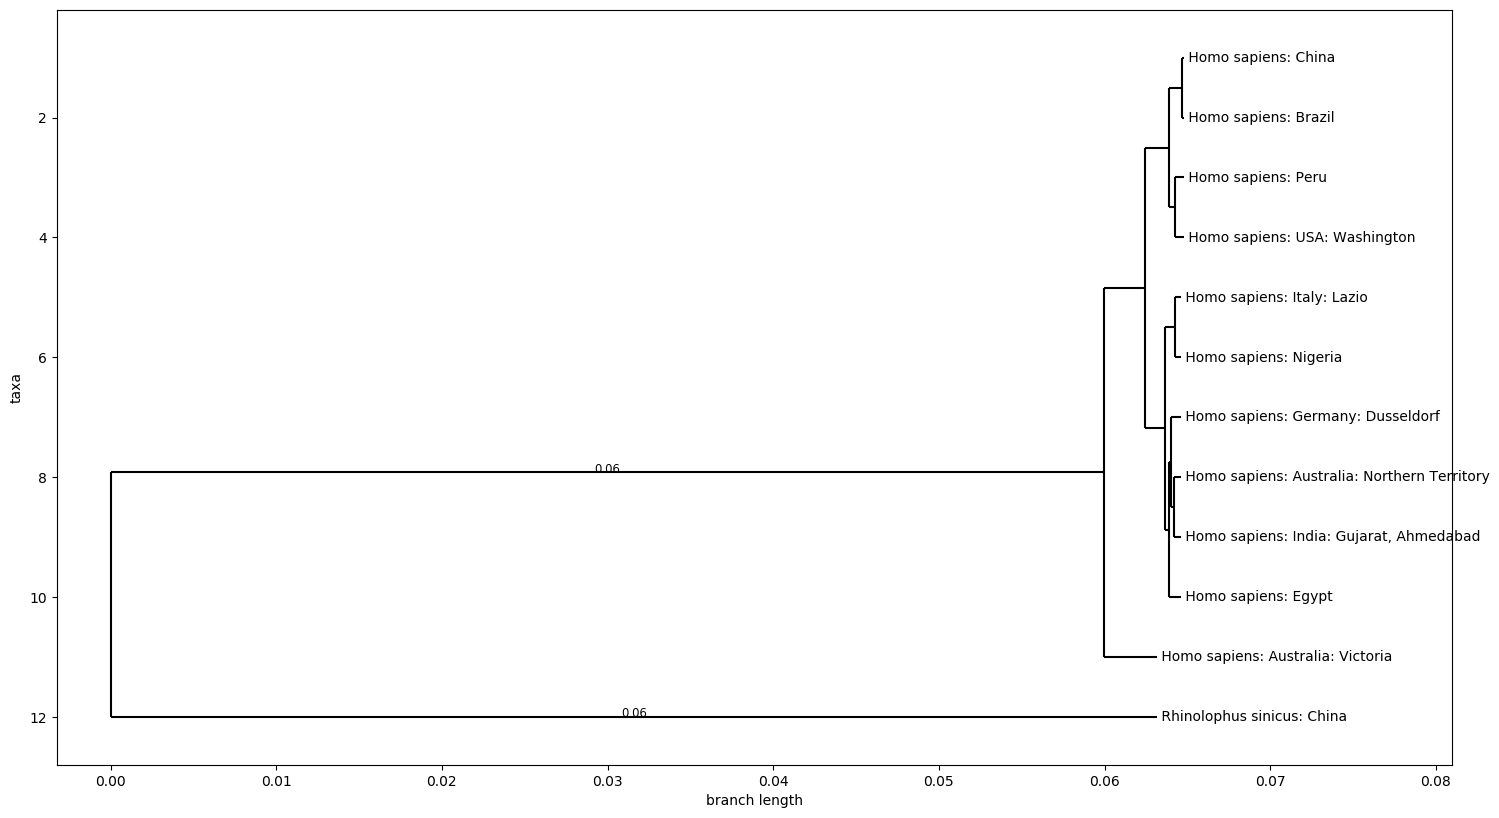

In [8]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('UPGMA_tree.png')


### Infer phyolgeny using the TreeTime algorithm
__1. TreeTime__ (Maximum Likelihood method):
- https://treetime.readthedocs.io/en/latest/tutorials.html
- temporally-resolved phylogeny
- considers the sequence alignments and is not solely based on sequential distance measures
- estimates the likelihood of a given tree topology to have produced the underlying data assuming a given model of evolution (relaxed-clock)
- evolutionary models provide time-dependent mutation probabilities
- reports topology with the highest likelihood (trees are scored)
- uses iqtree

installed with pip

command line program worked using collection date as date and accession id as name (accession ids in metadata and sequence names in alignment file need to match)

__Execution__:<br>
treetime --aln MSA.fasta --dates sequences_metadata.csv --date-column date --name-column Accession --outdir treetime_out


__2. Nextstrain:__
- https://nextstrain.org/docs/getting-started/introduction
- open-source tool for analysing and visualizing pathogen evolution and epidemiological spread
- for the purpose of scientific insights and improving outbreak respones in public health 
- Augur is the bioinformtaics toolkit of Nextstrain, Auspice is the visualization toolkit (https://docs.nextstrain.org/projects/augur/en/stable/usage/cli/refine.html)
- __Need to install nextstrain-augur and iqtree: !pip3 install nextstrain-augur, brew install brewsci/bio/iqtree__

uses iqtree for phylogeny inference and treetime algorithm for refinement

__Execution__:<br>
- infer tree from MSA: augur tree --alignment MSA.fasta --method iqtree --output augur_out/augur.out.nwk 

- get a time-resolved tree: augur refine --alignment MSA.fasta --tree augur_out/augur.out.nwk --metadata sequence_metadata.csv --output-tree augur_out/augur.out.refined.nwk --output-node-data augur_out/augur.refine.branches.json --timetree 

- annotate the tree with ancestral traits: augur traits --tree augur.out.refined.nwk --metadata ../sequence_metadata.csv --output traits.json --columns Geo_Location Host --confidence 
- infer ancestral sequence for each internal node (trace back mutations):  augur ancestral --tree augur.out.refined.nwk --alignment ../MSA.fasta --output-sequences nt_muts.json --inference joint
- export to auspice format: 
For sequence analysis and visualization follow the Zika tutorial: https://nextstrain.org/docs/tutorials/zika.

In [117]:
accession_metainfo

,Accession,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus
0,MT658507.1,2020-06-23T00:00:00Z,Severe acute respiratory syndrome-related coro...,29799,Egypt,Homo sapiens,oronasopharynx,2020-06-02,MT658507.1,Severe acute respiratory syndrome-related coro...
1,MT641501.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29868,USA: Washington,Homo sapiens,NaN,2020-04-11,MT641501.1,Severe acute respiratory syndrome-related coro...
2,MT641645.1,2020-06-19T00:00:00Z,Severe acute respiratory syndrome-related coro...,29813,Australia: Northern Territory,Homo sapiens,NaN,2020-02-21,MT641645.1,Severe acute respiratory syndrome-related coro...
3,MT635269.1,2020-06-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,29800,"India: Gujarat, Ahmedabad",Homo sapiens,NaN,2020-06-03,MT635269.1,Severe acute respiratory syndrome-related coro...
4,MT582453.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582453.1,Severe acute respiratory syndrome-related coro...
5,MT576584.1,2020-06-08T00:00:00Z,Severe acute respiratory syndrome-related coro...,29760,Nigeria,Homo sapiens,NaN,2020-03-01,MT576584.1,Severe acute respiratory syndrome-related coro...
6,MT525950.1,2020-05-28T00:00:00Z,Severe acute respiratory syndrome-related coro...,29760,Italy: Lazio,Homo sapiens,oronasopharynx,2020-03-01,MT525950.1,Severe acute respiratory syndrome-related coro...
7,MT451694.1,2020-05-11T00:00:00Z,Severe acute respiratory syndrome-related coro...,29812,Australia: Victoria,Homo sapiens,NaN,2020-04-01,MT451694.1,Severe acute respiratory syndrome-related coro...
8,MT350282.1,2020-04-17T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,Brazil,Homo sapiens,NaN,2020-03-18,MT350282.1,Severe acute respiratory syndrome-related coro...
9,MT263074.1,2020-03-31T00:00:00Z,Severe acute respiratory syndrome-related coro...,29856,Peru,Homo sapiens,NaN,2020-03-10,MT263074.1,Severe acute respiratory syndrome-related coro...


### Visualize phylogeny using Nextstrain auspice
Install: https://nextstrain.github.io/auspice/introduction/install

__Run in command line__

In [9]:
augur = Phylo.read('augur_out/augur.out.refined.nwk', 'newick')

In [10]:
print(augur)

Tree(rooted=False, weight=1.0)
    Clade(branch_length=0.001, name='NODE_0000002')
        Clade(branch_length=0.06417176, name='MG772933.1')
        Clade(branch_length=0.06587121, name='NODE_0000000')
            Clade(branch_length=0.00031266, name='MT641501.1')
            Clade(branch_length=8.376e-05, name='NODE_0000001')
                Clade(branch_length=1.34e-06, name='NODE_0000006')
                    Clade(branch_length=0.0, name='MN908947.3')
                    Clade(branch_length=9.705e-05, name='NODE_0000003')
                        Clade(branch_length=8.916e-05, name='MT350282.1')
                        Clade(branch_length=4.436e-05, name='MT641645.1')
                Clade(branch_length=9.786e-05, name='NODE_0000004')
                    Clade(branch_length=3.428e-05, name='NODE_0000005')
                        Clade(branch_length=4.163e-05, name='MT263074.1')
                        Clade(branch_length=2.612e-05, name='MT576584.1')
                    Clade(branc

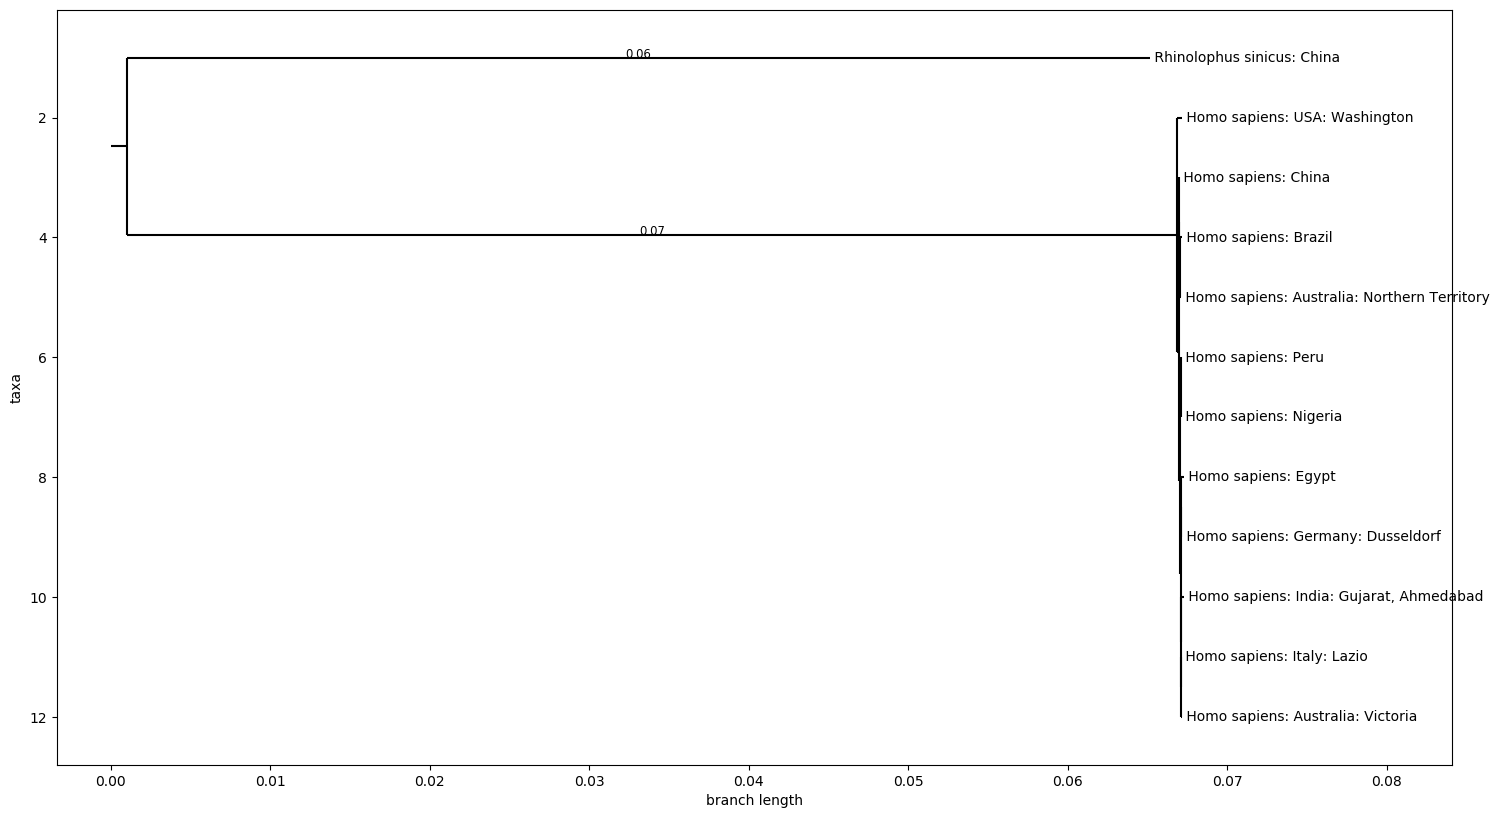

In [11]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(augur, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)


In [12]:
treetime = Phylo.read('treetime_out/timetree.nexus', 'nexus')

In [13]:
print(treetime)

Tree(name='tree1', rooted=False, weight=1.0)
    Clade(branch_length=0.1, comment='[&date=1923.25]', confidence='NODE_0000002')
        Clade(branch_length=93.83911, comment='[&mutations="A5T,A12T,T42C,G91A,A135-,C230T,A235T,A258G,T...', name='MG772933.1')
        Clade(branch_length=96.53211, comment='[&mutations="A3T,T4A,T37C,T100C,A101G,T129A,T140C,T190C,C...', confidence='NODE_0000000')
            Clade(branch_length=0.49803, comment='[&mutations="C1218T,A6703G,C17757T,A17868G,C18070T,C28546...', name='MT641501.1')
            Clade(branch_length=0.13714, comment='[&mutations="T5740C,T8792C,T14887C,C28171T",date=2019.92]', confidence='NODE_0000001')
                Clade(branch_length=-0.0, comment='[&date=2019.92]', name='MN908947.3')
                Clade(branch_length=0.06204, comment='[&mutations="G11093T",date=2019.98]', confidence='NODE_0000003')
                    Clade(branch_length=0.23327, comment='[&mutations="C2388T,C14815T,T17257C,T21804A,G26171T",date...', name='MT3

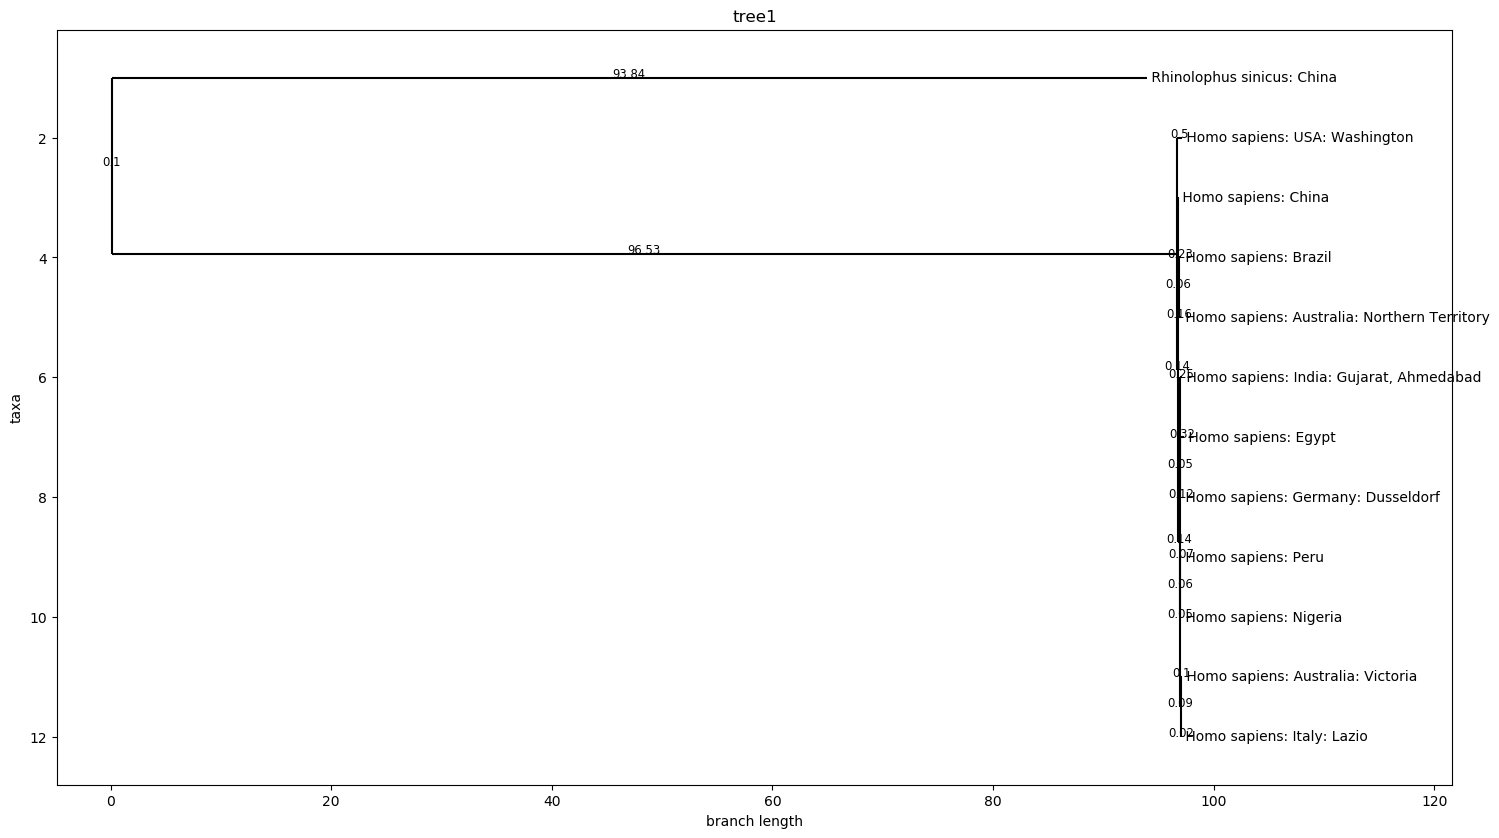

In [14]:
fig = plt.figure(figsize=(18, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

Phylo.draw(treetime, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)


# Cluster analysis in Germany

In [28]:
#with open("clustering/MT582447.1") as f: 
#    data = f.readlines() 
#with open("clustering/MSA_Germany.fasta", "w") as f: 
#    for line in data: 
#        out = line.replace(">gb|", ">")
#        f.write(out) 

In [201]:
align_germany = AlignIO.read("clustering/MSA_Germany.fasta", "fasta")
print(align_germany)

SingleLetterAlphabet() alignment with 16 rows and 29903 columns
--------------------------------------------...--- MT582447.1
--------------------------------------------...--- MT582446.1
--------------------------------------------...--- MT582490.1
--------------------------------------------...--- MT582497.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358638.1
--------------------------------------------...--- MT582498.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358641.1
--------------------------------------------...--- MT582494.1
--------------------------------------------...--- MT582484.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358639.1
--------------------------------------------...--- MT582487.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358643.1
--------------------------------------------...--- MT270108.1
--TAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT270106.1
-----------------------------AACCAACCAACTTTC...--- MT270103.1
------

In [40]:
#accession_metainfo = pd.read_csv("clustering/sequences.csv", index_col=0)
#
#accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
#accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')
#
## TreeTime and augur require the alignment file and metadata to have matching sequence names
#new_names = []
#for elem in accession_metainfo.index.values:
#    if elem.startswith('MN'):
#        new_names.append(elem+'.3')
#    else:
#        new_names.append(elem+'.1')
#accession_metainfo.index = new_names
#
## Nextstrain augur requires the metadata columns strain, virus and date
#accession_metainfo['strain'] = accession_metainfo.index
#accession_metainfo['virus'] = accession_metainfo.Species
#
#accession_metainfo.to_csv("clustering/sequence_metadata_germany.csv")

In [203]:
accession_metainfo_germany = pd.read_csv("clustering/sequence_metadata_germany.csv", index_col=0)
accession_metainfo_germany.head()

,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus
MT582446.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582446.1,Severe acute respiratory syndrome-related coro...
MT582447.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-20,MT582447.1,Severe acute respiratory syndrome-related coro...
MT582484.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-11,MT582484.1,Severe acute respiratory syndrome-related coro...
MT582487.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Dusseldorf,Homo sapiens,NaN,2020-03-11,MT582487.1,Severe acute respiratory syndrome-related coro...
MT582490.1,2020-06-09T00:00:00Z,Severe acute respiratory syndrome-related coro...,29782,Germany: Heinsberg,Homo sapiens,NaN,2020-02-28,MT582490.1,Severe acute respiratory syndrome-related coro...


In [202]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm_germany = calculator.get_distance(align_germany)

In [208]:
import seaborn as sns; sns.set(color_codes=True)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [204]:
# transform the diagonal matrix into a full rank matrix
cols = [accession_metainfo_germany["Geo_Location"][x] for x in dm_germany.names]
df_germany = pd.DataFrame(dm_germany.matrix, columns=cols, index=cols)
maxi = df_germany.shape[0]
for i in range(0,maxi):
    for j in range(i+1,maxi):
        df_germany.iloc[i,j] = df_germany.iloc[j,i]
df_germany.head()

,Germany: Dusseldorf,Germany: Dusseldorf,Germany: Heinsberg,Germany: Heinsberg,Germany,Germany: Heinsberg,Germany,Germany: Heinsberg,Germany: Dusseldorf,Germany,Germany: Dusseldorf,Germany,Germany: Bavaria,Germany: Bavaria,Germany: Bavaria,Germany: Bavaria
Germany: Dusseldorf,0.000000,0.010066,0.015116,0.016554,0.030499,0.026285,0.030398,0.026318,0.026318,0.030532,0.026519,0.030499,0.026419,0.029128,0.028191,0.026352
Germany: Dusseldorf,0.010066,0.000000,0.024914,0.026352,0.040297,0.036016,0.040197,0.036117,0.036117,0.040063,0.036050,0.040029,0.036016,0.038725,0.037789,0.035950
Germany: Heinsberg,0.015116,0.024914,0.000000,0.016286,0.015851,0.011638,0.015617,0.011537,0.011537,0.015885,0.011872,0.015851,0.011771,0.014480,0.013544,0.011705
Germany: Heinsberg,0.016554,0.026352,0.016286,0.000000,0.014079,0.009865,0.013845,0.009765,0.009765,0.014112,0.010099,0.014079,0.009999,0.012708,0.011771,0.009932
Germany,0.030499,0.040297,0.015851,0.014079,0.000000,0.004414,0.000301,0.004314,0.004314,0.000435,0.004515,0.000401,0.004414,0.001639,0.002508,0.004347


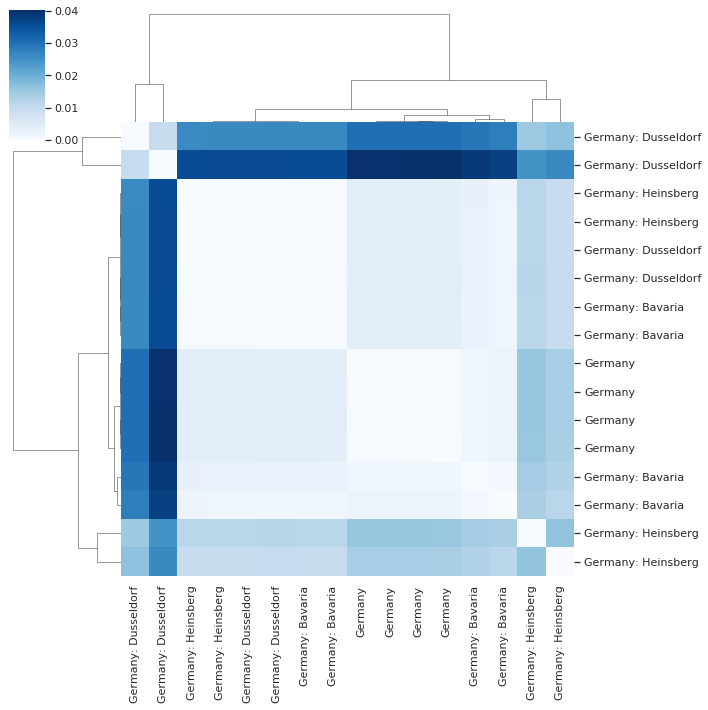

In [217]:
#use the UPGMA scoring for clustering
#linkage = hc.linkage(sp.distance.squareform(df_germany), method="average")
g = sns.clustermap(df_germany, cmap="Blues", method="average")#, row_linkage=linkage, col_linkage=linkage)

In [206]:
print("Mean Identity Distance in Germany:")
print(df_germany.mean().mean())

Mean Identity Distance in Germany:
0.010588663762833163


# Cluster analysis between Europe and Asia

In [111]:
#with open("clustering/MT256917.1") as f: 
#    data = f.readlines() 
#with open("clustering/MSA_EU_vs_Asia.fasta", "w") as f: 
#    for line in data: 
#        out = line.replace(">gb|", ">")
#        out = out.replace(">dbj|", ">")
#        f.write(out) 

In [112]:
align_eu_vs_asia = AlignIO.read("clustering/MSA_EU_vs_Asia.fasta", "fasta")
print(align_eu_vs_asia)

SingleLetterAlphabet() alignment with 20 rows and 29903 columns
--------------------------------------------...--- MT256917.1
-----AGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT372481.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT093571.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT576689.1
------------------------TAACAAACCAACCAACTTTC...--- MT630423.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT470105.1
ATTAAAGGTTTATACCTTTCCAGGTAACAAACCAACCAACTTTC...AAA MT511081.1
-----------ATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT560530.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT328033.1
----------TATACCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT517422.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT135042.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA LC549340.1
--------------CCTTCCCAGGTAACAAACCAACCAACTTTC...--- MT259230.1
--------------------------------CAACCAACTTTC...--- MT636895.1
ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTC...AAA MT358643.1
------

In [100]:
#accession_metainfo = pd.read_csv("clustering/sequences2.csv", index_col=0)
#
#accession_metainfo.rename(columns={'Collection_Date':'date'}, inplace=True)
#accession_metainfo.date = pd.to_datetime(accession_metainfo.date, format='%Y-%m-%d')
#
## TreeTime and augur require the alignment file and metadata to have matching sequence names
#new_names = []
#for elem in accession_metainfo.index.values:
#    new_names.append(elem+'.1')
#accession_metainfo.index = new_names
#
## Nextstrain augur requires the metadata columns strain, virus and date
#accession_metainfo['strain'] = accession_metainfo.index
#accession_metainfo['virus'] = accession_metainfo.Species
#
#accession_metainfo.to_csv("clustering/sequence_metadata_eu_vs_asia.csv")

In [101]:
accession_metainfo_eu_vs_asia = pd.read_csv("clustering/sequence_metadata_eu_vs_asia.csv", index_col=0)
accession_metainfo_eu_vs_asia.head()

,Release_Date,Species,Length,Geo_Location,Host,Isolation_Source,date,strain,virus
MT576689.1,2020-06-08T00:00:00Z,Severe acute respiratory syndrome-related coro...,29871,Bangladesh,Homo sapiens,oronasopharynx,2020-05-23,MT576689.1,Severe acute respiratory syndrome-related coro...
MT072667.1,2020-02-18T00:00:00Z,Severe acute respiratory syndrome-related coro...,670,Belgium,Homo sapiens,NaN,2020-02-03,MT072667.1,Severe acute respiratory syndrome-related coro...
MT135042.1,2020-03-04T00:00:00Z,Severe acute respiratory syndrome-related coro...,29903,China: Beijing,Homo sapiens,NaN,2020-01-28,MT135042.1,Severe acute respiratory syndrome-related coro...
MT259230.1,2020-03-30T00:00:00Z,Severe acute respiratory syndrome-related coro...,29866,"China: Hubei, Wuhan",Homo sapiens,oronasopharynx,2020-01-25,MT259230.1,Severe acute respiratory syndrome-related coro...
MT517422.1,2020-05-27T00:00:00Z,Severe acute respiratory syndrome-related coro...,29862,Czech Republic,Homo sapiens,oronasopharynx,2020-03-26,MT517422.1,Severe acute respiratory syndrome-related coro...


In [123]:
calculator = DistanceCalculator('identity')
# output = diagonal distance matrix
dm_eu_vs_asia = calculator.get_distance(align_eu_vs_asia)

In [52]:
#import seaborn as sns; sns.set(color_codes=True)
#import scipy.spatial as sp, scipy.cluster.hierarchy as hc

In [129]:
# transform the diagonal matrix into a full rank matrix
cols = [accession_metainfo_eu_vs_asia["Geo_Location"][x] for x in dm_eu_vs_asia.names]
df_eu_vs_asia = pd.DataFrame(dm_eu_vs_asia.matrix, columns=cols, index=cols)
maxi = df_eu_vs_asia.shape[0]
for i in range(0,maxi):
    for j in range(i+1,maxi):
        df_eu_vs_asia.iloc[i,j] = df_eu_vs_asia.iloc[j,i]
df_eu_vs_asia.head()

,Spain: Valencia,Malaysia,Sweden,Bangladesh,Saudi Arabia: Jeddah,France,Poland,Turkey,Greece,Czech Republic,China: Beijing,Japan:Tokyo,"China: Hubei, Wuhan",Russia: Moscow region,Germany,India: Ahmedabad,Iran,Belgium,Serbia,Thailand
Spain: Valencia,0.000000,0.106444,0.106009,0.105675,0.103434,0.106478,0.106678,0.105240,0.105642,0.105341,0.106344,0.106511,0.105140,0.112497,0.106544,0.103100,0.966258,0.973581,0.869578,0.984115
Malaysia,0.106444,0.000000,0.001505,0.002241,0.003344,0.000869,0.001070,0.002006,0.001906,0.002107,0.000836,0.000970,0.001639,0.012908,0.000903,0.003812,0.970137,0.977427,0.872086,0.988028
Sweden,0.106009,0.001505,0.000000,0.001204,0.002876,0.000970,0.001204,0.001304,0.000869,0.001405,0.000936,0.001070,0.000970,0.012440,0.001003,0.003344,0.969735,0.977026,0.871685,0.987627
Bangladesh,0.105675,0.002241,0.001204,0.000000,0.002608,0.001572,0.001471,0.000702,0.000401,0.000736,0.001672,0.001538,0.001304,0.011939,0.001471,0.002809,0.969267,0.976524,0.871117,0.987125
Saudi Arabia: Jeddah,0.103434,0.003344,0.002876,0.002608,0.000000,0.003378,0.003545,0.002107,0.002542,0.002207,0.003210,0.003478,0.002006,0.009999,0.003411,0.001204,0.967328,0.974618,0.869277,0.985185


In [116]:
# manual assignment for grouping the samples by continent
accession_metainfo_eu_vs_asia["Continent"] = ["Asia", "Europe", "Asia", "Asia", "Europe", "Europe", "Europe", "Europe", "Asia", "Asia", "Asia", "Asia", "Europe", "Europe", "Asia", "Europe", "Europe", "Europe", "Asia", "Asia"]
accession_metainfo_eu_vs_asia["Continent"].value_counts()

Europe    10
Asia      10
Name: Continent, dtype: int64

In [118]:
accession_metainfo_eu_vs_asia[["Geo_Location","Continent"]]

,Geo_Location,Continent
MT576689.1,Bangladesh,Asia
MT072667.1,Belgium,Europe
MT135042.1,China: Beijing,Asia
MT259230.1,"China: Hubei, Wuhan",Asia
MT517422.1,Czech Republic,Europe
MT470105.1,France,Europe
MT358643.1,Germany,Europe
MT328033.1,Greece,Europe
MT607604.1,India: Ahmedabad,Asia
MT598147.1,Iran,Asia


In [149]:
lut = dict(zip(accession_metainfo_eu_vs_asia["Continent"].unique(), "rg"))
lut2 = accession_metainfo_eu_vs_asia["Continent"].map(lut)
row_colors = [lut2[x] for x in dm_eu_vs_asia.names]

Colours:  {'Asia': 'r', 'Europe': 'g'}


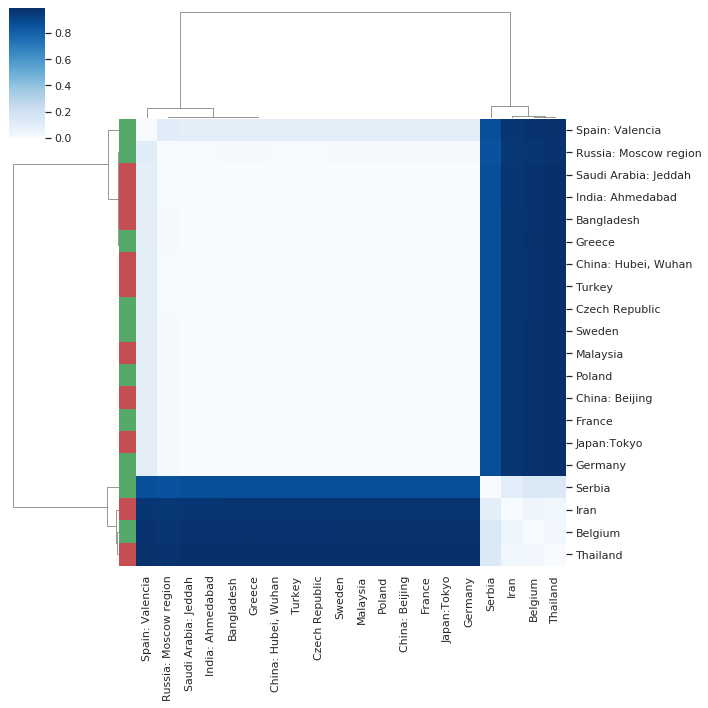

In [219]:
#use the UPGMA scoring for clustering
#linkage2 = hc.linkage(sp.distance.squareform(df_eu_vs_asia), method="average")
print("Colours: ", lut)
g = sns.clustermap(df_eu_vs_asia, cmap="Blues", row_colors=row_colors, method="average")#, row_linkage=linkage2, col_linkage=linkage2)

In [196]:
asia_list = accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia["Continent"]=="Asia"]["Geo_Location"].values
europe_list = accession_metainfo_eu_vs_asia[accession_metainfo_eu_vs_asia["Continent"]=="Europe"]["Geo_Location"].values

In [198]:
print("Mean Identity Distance between Europe and Asia:")
print((df_eu_vs_asia.filter(items=europe_list, axis=1).filter(items=asia_list, axis=0).mean().mean() + 
     df_eu_vs_asia.filter(items=asia_list, axis=1).filter(items=europe_list, axis=0).mean().mean()) / 2)
print("Mean Identity Distance in Europe:")
print(df_eu_vs_asia.filter(items=europe_list, axis=1).filter(items=europe_list, axis=0).mean().mean())
print("Mean Identity Distance in Asia:")
print(df_eu_vs_asia.filter(items=asia_list, axis=1).filter(items=asia_list, axis=0).mean().mean())
print("Mean Identity Distance total:")
print(df_eu_vs_asia.mean().mean())

Mean Identity Distance between Europe and Asia:
0.3174393873524396
Mean Identity Distance in Europe:
0.3150051834264121
Mean Identity Distance in Asia:
0.31492626157910575
Mean Identity Distance total:
0.3162025549275993
